# TP 2 - algoritmos de ensambles 

El objetivo de este trabajo práctico es analizar las particularidades de la utilización de algoritmos de ensambles aplicados en casos casi reales. El mismo pretende fijar conceptos estudiados en la teoría: métodos de ensamble; random forests; boosting; sobreajuste; tolerancia al ruido. El material básico para la elaboración del presente trabajo se encuentra en las teóricas y prácticas presentadas hasta el momento y en las próximas clases y en las referencias bibliográficas indicadas [1,2,3]. Podrá utilizarse cualquier otra fuente siempre que esté correctamente referenciada.
El presente trabajo será grupal. El grupo deberá estar compuesto por exactamente tres integrantes. Se evaluarán los contenidos del Trabajo Práctico durante el coloquio posterior a la entrega del TP junto al material teórico y práctico enseñado en las clases de toda la materia. Todos los integrantes deben tener conocimiento del desarrollo del TP.

**Opcionales (dan puntos extra)**:

* Sumar al punto c) un modelo de perceptrón multicapa.
* Evaluar el desempeño de los modelos al utilizar el conjunto de atributos ComParE 2016.

**La fecha límite de entrega es el lunes 28 de junio a las 17:00 hs.**

**tbd** 
* Sacar a otro notebook la búsqueda de hiperparámetros de adabost, randomforest y bagging
* Sacar a otro notebook el entrenamiento del perceptron

## Cargar librerias


In [41]:
import datetime
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sweetviz as sv
import time
from matplotlib import pyplot
from numpy import mean
from numpy import std
from urllib.parse import urlparse

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [53]:
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.calibration import calibration_curve
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_curve,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import pickle
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

In [44]:
# # Observación: Descomentar en caso de que quieran versionar los modelos y la búsqueda de hiperparámetros.
# import mlflow
# import mlflow.sklearn
# from mlflow.tracking import MlflowClient

## Cargar dataset

In [45]:
df_original = pd.read_csv("01.df.procesado.csv")
# df_original = pd.read_csv("https://raw.githubusercontent.com/blukitas/AA-2021/main/TPs/02.TP/01.df.procesado.csv")
df_original.head()

,Unnamed: 0,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,start,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,./audios/ravdess/Actor_23/03-01-07-02-02-01-23...,3,1,7,2,2,1,23,0 days 00:00:00,...,0.075190,0.014015,0.022255,2.150538,1.089918,0.2825,0.126763,0.4900,0.397291,-36.658245
1,1,./audios/ravdess/Actor_23/03-02-03-02-02-01-23...,3,2,3,2,2,1,23,0 days 00:00:00,...,0.020998,0.009869,0.018871,1.492537,0.646552,0.8200,0.277248,0.5275,0.438770,-29.391884
2,2,./audios/ravdess/Actor_23/03-01-04-01-02-01-23...,3,1,4,1,2,1,23,0 days 00:00:00,...,0.047365,0.011048,0.011381,2.247191,0.569801,0.5900,0.160000,0.7600,0.296985,-43.332924
3,3,./audios/ravdess/Actor_23/03-02-04-02-02-01-23...,3,2,4,2,2,1,23,0 days 00:00:00,...,0.041743,0.012340,0.007390,1.394422,0.603622,0.9300,0.885701,0.5275,0.420260,-37.549572
4,4,./audios/ravdess/Actor_23/03-01-02-02-02-02-23...,3,1,2,2,2,2,23,0 days 00:00:00,...,0.053580,0.011590,0.005245,1.535088,0.886918,0.3875,0.206079,0.5740,0.424999,-43.261425


In [46]:
num_columns = [col for col in df_original.columns if df_original[col].dtype != "object"]
num_columns

['Unnamed: 0',
 'modality',
 'vocal_channel',
 'emotion',
 'emotional_intensity',
 'statement',
 'repetition',
 'actor',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1

In [47]:
drop_columns = [
    "file_path",
    "Unnamed: 0",
    "modality",
    "vocal_channel",
#     "emotion",
    "emotional_intensity",
    "statement",
    "repetition",
#     "actor",
]
num_columns = [x for x in num_columns if x not in drop_columns]
num_columns

['emotion',
 'actor',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3

In [48]:
df_proc = df_original[num_columns] #.head(10000)

## Split del dataset

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_proc.loc[:, df_proc.columns != "emotion"],
    df_proc["emotion"],
    stratify=df_proc["emotion"],
    random_state=66,
)

## Desarrollo de modelos de ensamble

B) Elegir un modelo de ensamble visto durante las clases y entrenarlo para predecir emociones dividiendo el dataset de las siguientes maneras:
    i) 12-fold cross validation armando los folds de forma aleatoria.
    ii) Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos. Se recomienda utilizar la función de sklearn LeaveOneGroupOut

Reportar los resultados obtenidos y realizar un análisis de los mismos, teniendo en cuenta las características del dataset utilizado.

### Métricas

f1

Si no está desbalanceado accuracy puede ser bien. F1 es un poco más robusta, pensando en que tiene en cuenta recall y precision.

No hay elementos que inclinen la balanza.

<BarContainer object of 8 artists>

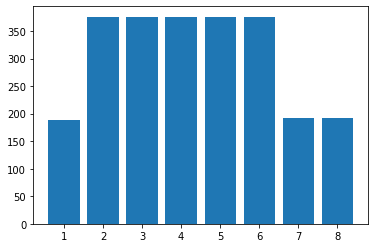

In [10]:
plt.bar(
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count(),
)

#### Setup mlflow
Mlflow es una herramienta para versionado de modelos. Permite registrar paramétros, métricas y guardar los modelos entrenados asociados a una iteración.

En caso de no ser necesario comentar estas lineas.

In [25]:
# # now = datetime.datetime.now()
# mlflow.set_tracking_uri("http://mlflow_server:5000")
# tracking_uri = mlflow.get_tracking_uri()
# print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://mlflow_server:5000


In [26]:
# # No hace falta el create, el set lo crea si no existe
# experiment = mlflow.set_experiment(
#     "AA.TP2.Bagging.{0}".format(now.strftime("%Y-%m-%d"))
# )

INFO: 'AA.TP2.RandomizedSearchCV.2021-06-24' does not exist. Creating a new experiment


### Método elegido -> Bagging

Bagging con n árboles


Combinan strong learners, los cuales tienen varianza alta, para reducir su varianza. El bagging consiste en utilizar distintos subsets de los datos de entrenamiento para entrenar cada learner. Los subsets se generan tomando muestras con reemplazo. Si no se hace reemplazo se denomina **pasting**, y si en lugar de tomar subsets sobre los datos, los tomamos sobre los atributos, se denomina **random subspaces**. La combinación de bagging y random subspaces se denomina **random patches**.

https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting

Scikit Learn cuenta un tipo de objetos llamados meta-estimadores para representar a los ensambles. Este nombre se debe a que estos meta-estimadores necesitan definir estimadores base que van a ser justamente los modelos que se ajusten en cada uno de los pasos de bootstrapping. Como modelos/estimadores base podemos instanciar cualquier estimador de sklearn. Para el caso de Bagging, el meta-estimador para clasificación es:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Este objeto tiene como principal parámetro a base_estimator en el cual instanciaremos un modelo. Veamos un pequeño ejemplo:

**tbd** Acomodarlo a los árboles que usamos

In [24]:
# Version 0 del árbol

# kfold = KFold(n_splits = 12,
#                        random_state = 42, shuffle=True)
  
# # initialize the base classifier
# # TBD: Inicializar con el mejor árbol
# #      ¿Se puede inicializar con n arboles?
# # TBD: Hacer un par y compararlos? Tiene sentido?
# base_cls = DecisionTreeClassifier()
  
# # no. of base classifier
# num_trees = 1000
  
# # bagging classifier
# model = BaggingClassifier(base_estimator = base_cls,
#                           n_estimators = num_trees,
#                           random_state = 42)
  
# # max_samples en float nos dice que porcentaje del training set queremos remuestrear
# # max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos
# results = cross_val_score(model, X_train, y_train, cv = kfold)

# # fit
# model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  random_state=42)

In [54]:
start = time.time()

kfold = StratifiedKFold(n_splits=12, random_state=42, shuffle=True)
scorer_fn = make_scorer(
    f1_score, average="weighted"
)  # seteamos una metrica apropiada al problema multiclase

base_cls = DecisionTreeClassifier(class_weight="balanced")

# no. of base classifier
num_trees = 1000

# bagging classifier
model = BaggingClassifier(
    base_estimator=base_cls,
    n_estimators=num_trees,
    random_state=123,
    # shuffle=True,
    n_jobs=10,
    verbose=True,
)

results_f1 = cross_val_score(
    estimator=model, X=X_train, y=y_train, cv=kfold, n_jobs=10, scoring=scorer_fn
)
model.fit(X_train, y_train)

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   21.6s remaining:  1.4min


Tiempo: 275.89 segundos


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   22.8s finished


In [55]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(model, open('03.02.Bagging_stratified_balanced.pkl', 'wb'))

## Comparación de modelos

C) Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

1. Train/Test
2. Métrica
3. Busqueda hiperparámetros (Cuáles son los hiperparametros? Cual el espacio de búsqueda acotado?)
    * Random forest
    * Adaboost
4. Comparación de modelos
    * Matriz de confusión
5. Comprar ambos modelos
    * Cantados
    * Hablados

### Métrica

f1

### Random Forests

Random Forest es una implementación de un algoritmo de *Bagging* que propone como estimadores base a **n_estimators** árboles de decisión. Cada árbol verá un subset distinto de los datos de entrenamiento (bagging, llamado **bootstrap** en los parámetros de sklearn). A su vez, para elegir el mejor split en cada nivel, se tienen en cuenta solo **max_features** atributos, seleccionados al azar. Estas 2 técnicas combinadas llevan a obtener árboles que sean distintos entre si y estén decorrelacionados, lo cual es bueno ya que si un árbol comete errores, probablemente otros no lo cometerán y se compensarán. Cuanto más independientes sean los árboles entre si más reduciremos la varianza.

random forest pelado

In [156]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy training : 1.000
Accuracy test: 0.726


In [ ]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(rf, open('03.03.Random_forest.pkl', 'wb'))

In [182]:
# now = datetime.datetime.now()
# mlflow.set_tracking_uri("http://mlflow_server:5000")
# tracking_uri = mlflow.get_tracking_uri()
# print("Current tracking uri: {}".format(tracking_uri))

# # No hace falta el create, el set lo crea si no existe
# experiment = mlflow.set_experiment(
#     "AA.TP2.RandomForest.{0}".format(now.strftime("%Y-%m-%d"))
# )

Current tracking uri: http://mlflow_server:5000


Busqueda de hiperparametros random forest 

In [185]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
start = time.time()

parameters = {
    "n_estimators": range(50, 5000, 500),
    "bootstrap": [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
}
kfoldcv = StratifiedKFold(n_splits=12)
clf = RandomizedSearchCV(
    RandomForestClassifier(max_features=None),
    parameters,
    n_jobs=10,
    scoring=scorer_f1,
    cv=kfoldcv,
    n_iter=100,
    verbose=10,
    random_state=42
)
clf.fit(X_train, y_train)
end = time.time()

Fitting 12 folds for each of 10 candidates, totalling 120 fits


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [186]:
# Tiempo de búsqueda de hiperparámetros
print(f"Tiempo: { round(end - start, 2) } segundos")

Tiempo: 5044.0 segundos


In [187]:
rf = clf.best_estimator_
print(clf.best_score_, clf.best_params_)

0.6508652471656616 {'n_estimators': 3050, 'bootstrap': True}


In [188]:
# Visualizar las opciones que nos devolvió
aux = pd.DataFrame(clf.cv_results_).head()

In [189]:
aux.to_csv('03.04.AA.TP2.RandomForest.{0}.csv'.format(now.strftime("%Y-%m-%d")))

In [190]:
# # Explorar la columnas para registrarlas en mlflow
# params = [x for x in aux.columns if "param_" in x]
# print(params)
# score = [x for x in aux.columns if "score" in x]
# print(score)
# col_time = [x for x in aux.columns if "time" in x]
# print(time)

['param_n_estimators', 'param_bootstrap']
['mean_score_time', 'std_score_time', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'split10_test_score', 'split11_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
<module 'time' (built-in)>


In [191]:
# # Registro y versionado de modelo en mlflow
# #   Comentar en caso de no estar utilizandolo

# start = time.time()
# for index, row in aux.iterrows():
#     with mlflow.start_run(experiment):
#         mlflow.log_param('Busqueda', 'RandomizedSearchCV')
#         for i in params:
#             # print('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_param(i, row[i])

#         for i in score:
#             # print('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])

#         for i in col_time:
#             # print('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])
# end = time.time()
# print(f"Tiempo: { end - start }")

Tiempo: 1.7944324016571045


In [199]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(clf, open('03.04.Random_forest_search.pkl', 'wb'))

In [200]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(rf, open('03.04.Random_forest.pkl', 'wb'))

In [201]:
# En caso de estar reejecutando => load model
# loaded_model = pickle.load(open('03.02.Bagging_balanced.pkl', 'rb'))
loaded_model = pickle.load(open('03.04.Random_forest.pkl', 'rb'))

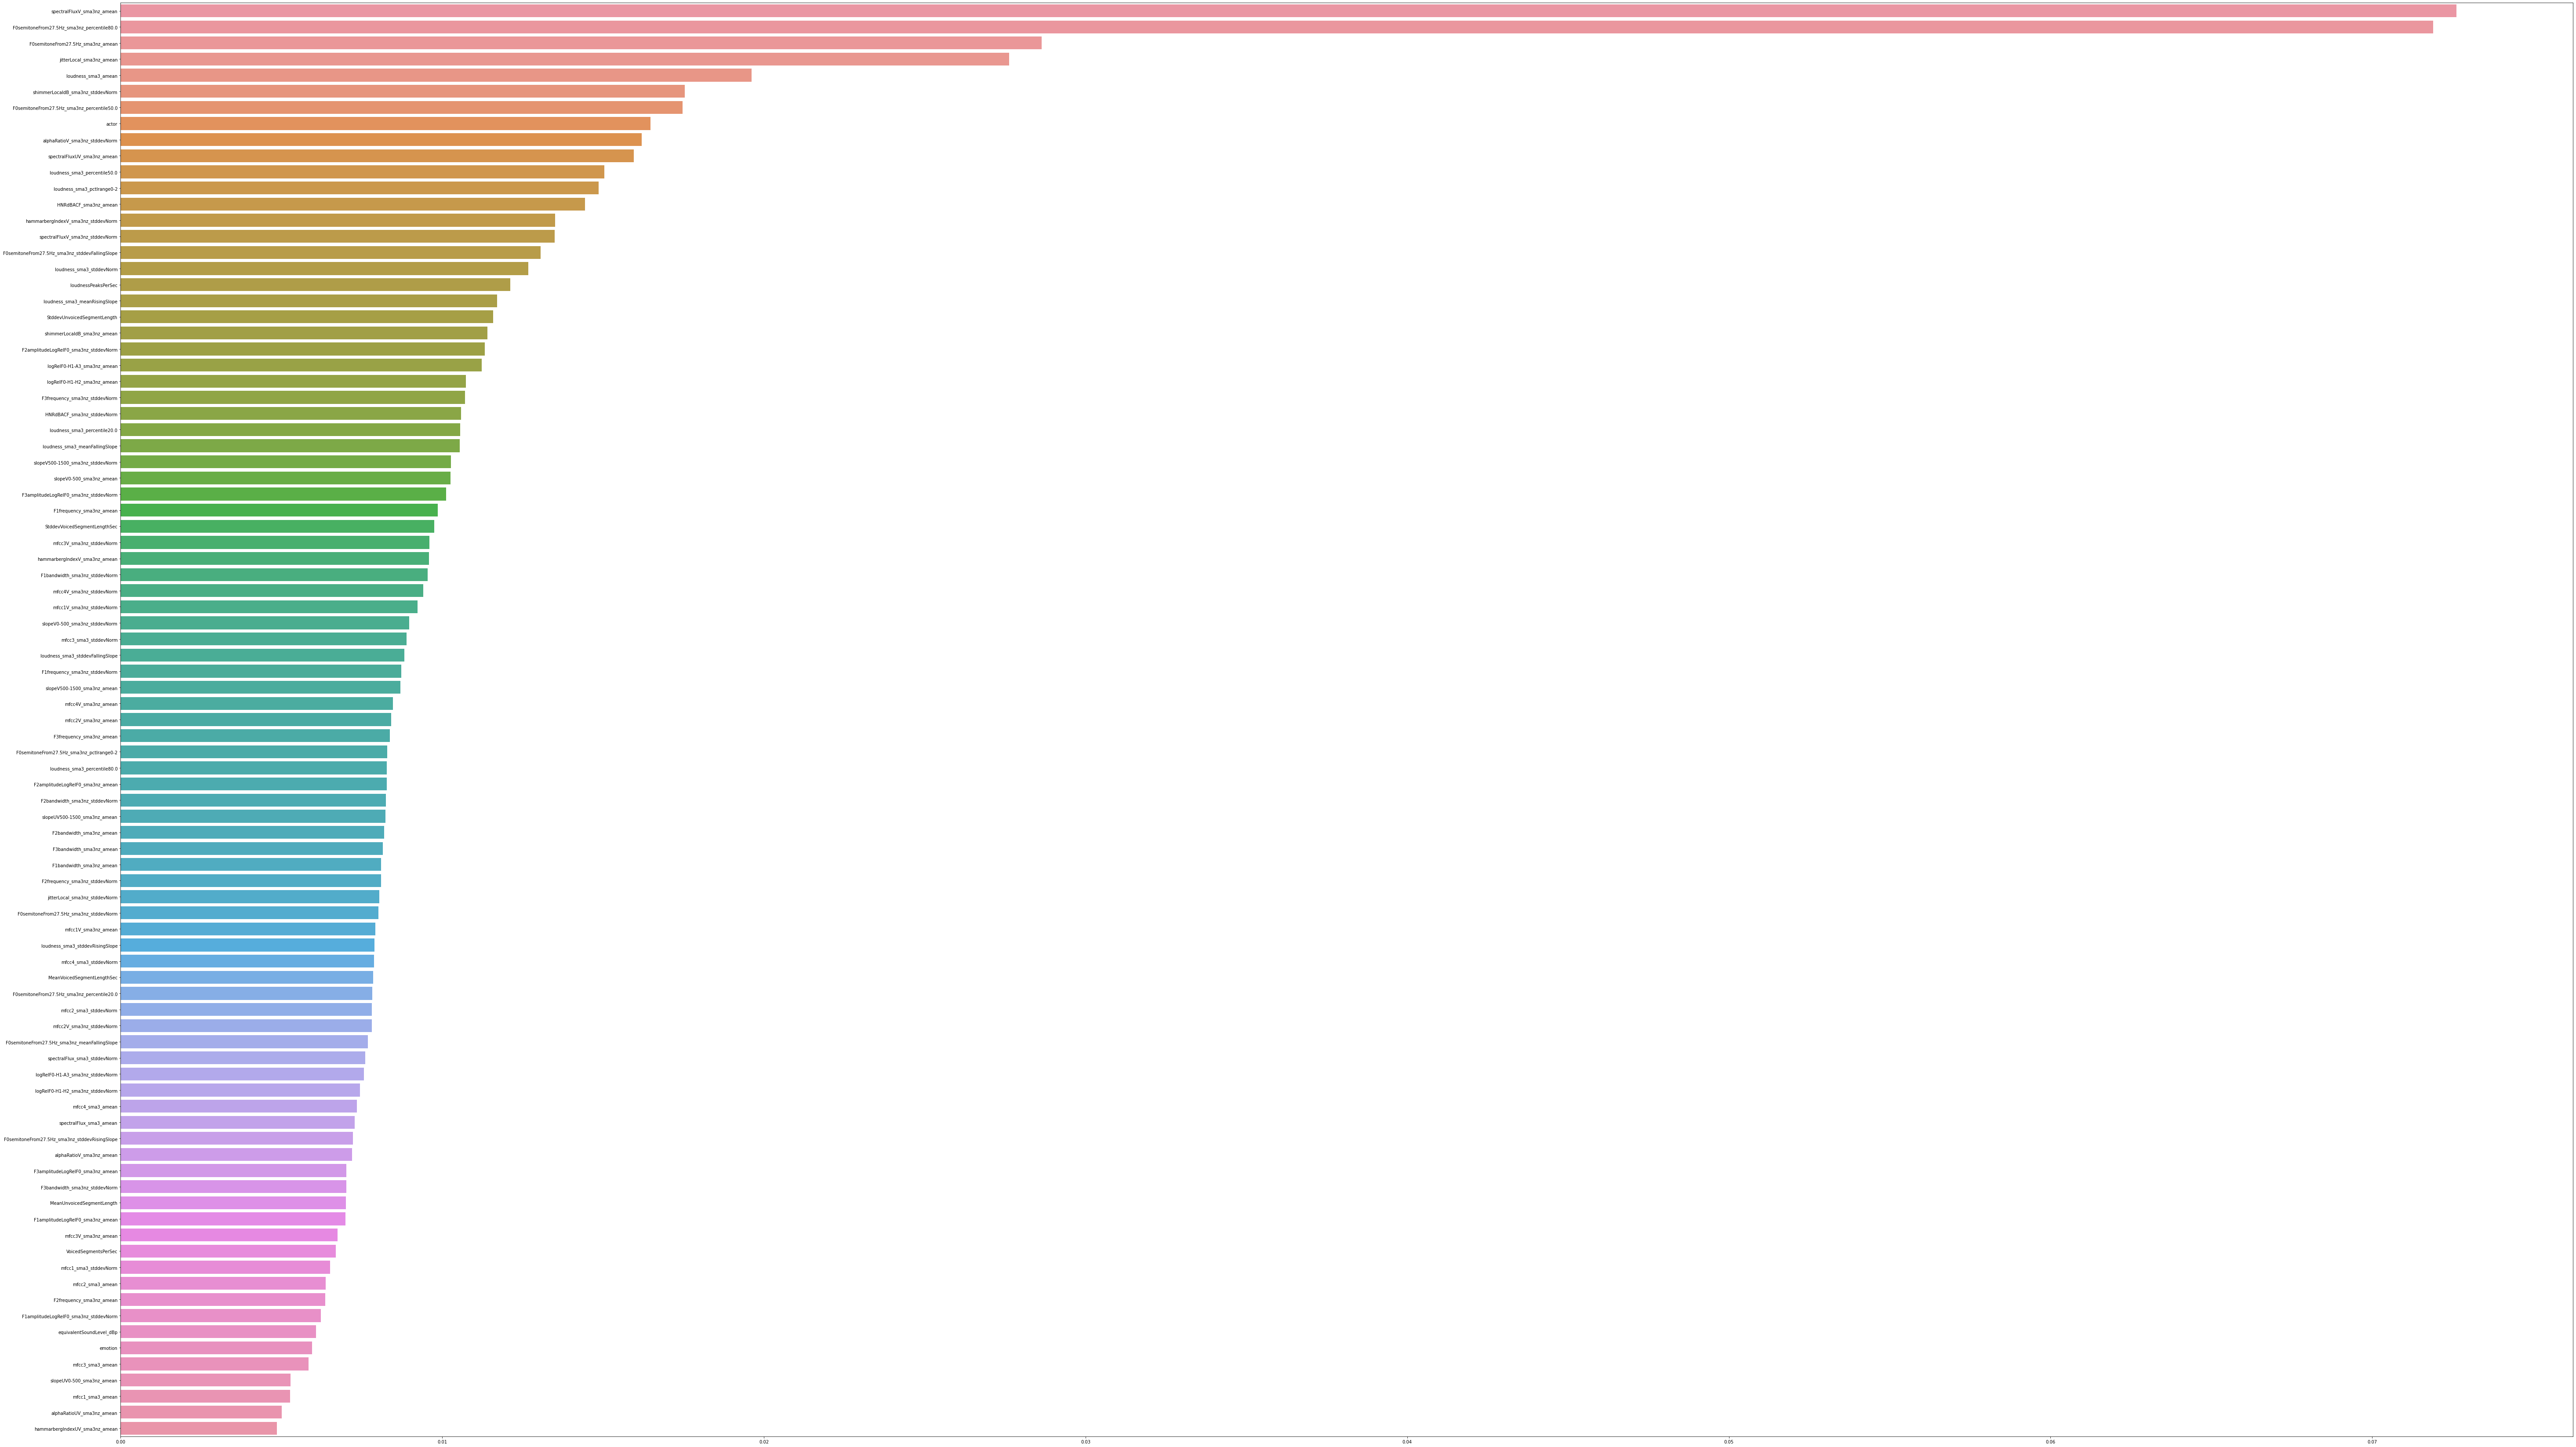

In [202]:
features = [x for i, x in enumerate(df_proc.columns) if i != 8]
feat_importances = loaded_model.feature_importances_

plt.figure(figsize=(100, 60))
graph_importance = sns.barplot(
    y=features,
    x=feat_importances,
    orient="h",
    order=reversed(np.array(features)[np.argsort(feat_importances)]),
)


graph_importance.figure.savefig(
    "03.04.Random_forest.feature_importante.png", bbox_inches='tight'
)

In [203]:
# df_proc.loc[:, df_proc.columns != "emotion"],
#     df_proc["emotion"],
    
importancia_predictores = pd.DataFrame(
    {"Predictor": df_proc.loc[:, df_proc.columns != "emotion"], "Importancia": loaded_model.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,Importancia
67,"(s, p, e, c, t, r, a, l, F, l, u, x, V, _, s, ...",0.072617
6,"(F, 0, s, e, m, i, t, o, n, e, F, r, o, m, 2, ...",0.071894
2,"(F, 0, s, e, m, i, t, o, n, e, F, r, o, m, 2, ...",0.028634
31,"(j, i, t, t, e, r, L, o, c, a, l, _, s, m, a, ...",0.027618
11,"(l, o, u, d, n, e, s, s, _, s, m, a, 3, _, a, ...",0.019615
...,...,...
27,"(m, f, c, c, 3, _, s, m, a, 3, _, a, m, e, a, n)",0.005837
79,"(s, l, o, p, e, U, V, 0, -, 5, 0, 0, _, s, m, ...",0.005278
23,"(m, f, c, c, 1, _, s, m, a, 3, _, a, m, e, a, n)",0.005272
77,"(a, l, p, h, a, R, a, t, i, o, U, V, _, s, m, ...",0.005013


In [204]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
# evaluación
print("Accuracy training : {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(clf.score(X_test, y_test)))
print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test, average='weighted')))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1, average='weighted')))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2, average='weighted')))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.4s remaining:    5.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.8s finished


Accuracy training : 1.000
Accuracy test: 0.689
Train acc: 1.0
Test acc: 0.6818923327895595
Test recall: 0.6818923327895595
Test F1: 0.6796129964914231
Test F2: 0.6805313701798359


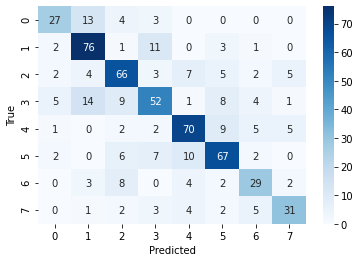

In [206]:
cm = confusion_matrix(y_test, y_pred_test)
matriz_n_aria = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")


matriz_n_aria .figure.savefig(
    "03.04.Random_forest.matriz.png", bbox_inches='tight'
)

### AdaBoost
En cada iteración construye un stump nuevo y le da más peso a las muestras que fueron clasificadas mal por el anterior stump. De esta manera, en cada iteración se intenta corregir los errores que cometió el anterior clasificador. Una vez armado el ensamble, cada stump tendrá asociado un peso en sus predicciones de acuerdo a qué tan bueno fue clasificando durante el entrenamiento. A continuación les dejamos un video explicativo del funcionamiento del algoritmo:

https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

La implementación de AdaBoost de sklearn nos provee de un meta-estimador para Boosting, al cual le podemos pasar cualquier estimador (por defecto usa un arbol de profundidad 1, un stump):

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier

Paper original:
https://web.stanford.edu/~hastie/Papers/samme.pdf 


In [211]:
start = time.time()
kfold = StratifiedKFold(n_splits=12, random_state=42, shuffle=True)
from sklearn.ensemble import AdaBoostClassifier

parameters = {
    "n_estimators": range(10, 3000, 5),
    "learning_rate": np.arange(0, 3, 0.001),
}
clf = RandomizedSearchCV(
    AdaBoostClassifier(DecisionTreeClassifier(class_weight="balanced")),
    parameters,
    n_jobs=12,
    scoring=scorer_f1,
    cv=kfold,
    n_iter=1000,
    verbose=10
)

clf.fit(X_train, y_train)

Fitting 12 folds for each of 1000 candidates, totalling 12000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=12, random_state=42, shuffle=True),
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced')),
                   n_iter=1000, n_jobs=12,
                   param_distributions={'learning_rate': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 2.997e+00, 2.998e+00,
       2.999e+00]),
                                        'n_estimators': range(10, 3000, 5)},
                   scoring=make_scorer(fbeta_score, beta=1, average=weighted),
                   verbose=10)

In [212]:
ab = clf.best_estimator_

In [213]:
print(clf.best_score_, clf.best_params_)

0.4797936868934203 {'n_estimators': 1640, 'learning_rate': 0.707}


In [221]:
print("F1-score training : {:.3f}".format(ab.score(X_train, y_train)))
print("F1-score test: {:.3f}".format(ab.score(X_test, y_test)))


F1-score training : 1.000
F1-score test: 0.501


In [216]:
end = time.time()
print(f"Tiempo: { end - start }")

Tiempo: 8455.91315793991


In [217]:
import pickle

now = datetime.datetime.now()

pickle.dump(ab, open('03.05.tst.AdaBoost_clf.pkl', 'wb'))
pickle.dump(ab, open('03.05.tst.AdaBoost.pkl', 'wb'))

clf_results = pd.DataFrame(clf.cv_results_)

clf_results.to_csv('03.05.tst.AdaBoost.csv')
clf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score
0,0.312341,0.065797,0.007570,0.003888,790,0.993,"{'n_estimators': 790, 'learning_rate': 0.993}",0.485371,0.492019,0.537778,...,0.463211,0.348125,0.481268,0.407820,0.470043,0.493994,0.544937,0.474246,0.051502,32
1,0.368753,0.081882,0.008263,0.004344,1795,0.055,"{'n_estimators': 1795, 'learning_rate': 0.055}",0.458253,0.474053,0.520896,...,0.476098,0.375611,0.487744,0.436675,0.445834,0.462894,0.498038,0.461984,0.035132,672
2,0.338972,0.085696,0.007404,0.004614,1200,2.647,"{'n_estimators': 1200, 'learning_rate': 2.6470...",0.468109,0.479501,0.511203,...,0.491287,0.355365,0.485713,0.445866,0.476502,0.505472,0.521034,0.472943,0.040853,51
3,0.338519,0.088696,0.009492,0.006785,2380,1.849,"{'n_estimators': 2380, 'learning_rate': 1.849}",0.463310,0.474853,0.471425,...,0.499514,0.386757,0.501415,0.440299,0.416511,0.505262,0.506334,0.463980,0.037177,514
4,0.357867,0.078722,0.007722,0.003123,2230,2.335,"{'n_estimators': 2230, 'learning_rate': 2.335}",0.440888,0.480001,0.534314,...,0.498356,0.348614,0.470511,0.459855,0.469475,0.492529,0.528018,0.470553,0.045581,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.355479,0.077183,0.008627,0.004934,2045,0.825,"{'n_estimators': 2045, 'learning_rate': 0.8250...",0.462068,0.494697,0.539594,...,0.510864,0.368941,0.465417,0.428703,0.457098,0.467237,0.519842,0.469050,0.045485,177
996,0.393598,0.073627,0.008605,0.005559,1675,0.576,"{'n_estimators': 1675, 'learning_rate': 0.5760...",0.441030,0.445929,0.469096,...,0.453050,0.381350,0.472325,0.413192,0.451806,0.478399,0.500033,0.449262,0.029596,997
997,0.372186,0.080256,0.008627,0.004977,2880,0.727,"{'n_estimators': 2880, 'learning_rate': 0.727}",0.445288,0.471898,0.530107,...,0.495769,0.367052,0.509889,0.409663,0.471712,0.465425,0.496268,0.463954,0.042890,516
998,0.365995,0.087233,0.012433,0.008290,2090,0.404,"{'n_estimators': 2090, 'learning_rate': 0.404}",0.453355,0.457938,0.480697,...,0.455941,0.358747,0.494463,0.431024,0.442845,0.496480,0.530271,0.456331,0.041061,938


In [219]:

# matriz de confusión y classification_report
y_pred_test = ab.predict(X_test)
confusion_matrix(y_test, y_pred_test)

array([[25,  2,  7,  8,  1,  2,  2,  0],
       [ 2, 60,  5, 17,  0,  8,  1,  1],
       [ 2,  5, 49,  7,  7, 13,  2,  9],
       [10, 13,  7, 37,  4, 15,  5,  3],
       [ 1,  0,  8,  2, 62, 12,  6,  3],
       [ 2,  1, 16, 15, 16, 37,  3,  4],
       [ 1,  0,  8,  4,  7,  4, 19,  5],
       [ 0,  4,  9,  1,  4,  2, 10, 18]])

Text(33.0, 0.5, 'True')

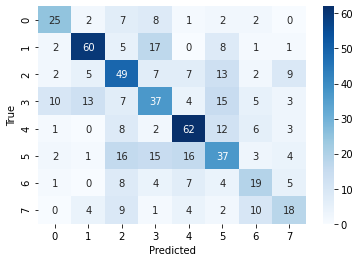

In [220]:
# heat map
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")